In [15]:
# --- CELL 1: IMPORTS & SETUP ---
import osmnx as ox
import networkx as nx
import folium
import numpy as np
import pandas as pd
import dimod
import neal
import pulp
import random
import time

# --- CONFIGURATION (HARD MODE) ---
CITY_NAME = "Delhi, India"  # The Digital Twin Location
NUM_CANDIDATE_SITES = 30     # Total possible locations
NUM_HUBS_TO_BUILD = 5        # Budget
SEED = 42

# TUNING KNOBS (The "Secret Sauce" for Quantum Advantage)
# We increase beta to 10.0 to force the solver to prioritize spacing.
ALPHA = 1.0        # Importance of Demand
BETA = 15.0        # Importance of Avoiding Overlap (Penalty)
DECAY = 0.5        # "Blast Radius" of a hub (Higher = wider influence)
GAMMA = 150.0      # Constraint Penalty (Must pick exactly 5)

print("Configuration Loaded. Ready to build the Digital Twin.")

Configuration Loaded. Ready to build the Digital Twin.


In [2]:
# --- CELL 2: REAL WORLD DATA GENERATION ---
print(f"1. Downloading Street Network for: {CITY_NAME}...")

# 1. Get the Graph from OpenStreetMap (Drive Network)
G = ox.graph_from_place(CITY_NAME, network_type='drive', simplify=True)
all_nodes = list(G.nodes())

# 2. Select Candidate Sites (Simulating Available Warehouses)
random.seed(SEED)
candidate_nodes = random.sample(all_nodes, NUM_CANDIDATE_SITES)

# 3. Generate Synthetic Demand (Orders per Hub)
np.random.seed(SEED)
demand_scores = np.random.randint(20, 100, size=NUM_CANDIDATE_SITES)

print("2. Calculating 'Drive-Time' Distance Matrix...")
# This replaces simple geometry with real logistics math
dist_matrix = np.zeros((NUM_CANDIDATE_SITES, NUM_CANDIDATE_SITES))

for i in range(NUM_CANDIDATE_SITES):
    for j in range(NUM_CANDIDATE_SITES):
        if i == j:
            dist_matrix[i][j] = 0
        else:
            try:
                # Calculate shortest path on the actual road network
                d = nx.shortest_path_length(G, candidate_nodes[i], candidate_nodes[j], weight='length')
                dist_matrix[i][j] = d
            except nx.NetworkXNoPath:
                dist_matrix[i][j] = 999999 # Infinite distance if unreachable

# 4. Create the Overlap Matrix (The 'Risk' Model)
max_dist = np.max(dist_matrix)
normalized_dist = dist_matrix / max_dist
# We use the new DECAY factor to make overlap penalty stronger
overlap_matrix = np.exp(-normalized_dist / DECAY)
np.fill_diagonal(overlap_matrix, 0.0)

print("Digital Twin Ready: Real-world distances calculated.")

1. Downloading Street Network for: Delhi, India...
2. Calculating 'Drive-Time' Distance Matrix...
Digital Twin Ready: Real-world distances calculated.


In [20]:
# --- CELL 3: QUANTUM OPTIMIZATION (QUBO) ---
print("3. Building Quantum Model...")

bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

# A. Linear Terms (Maximize Demand -> Minimize Negative Demand)
for i in range(NUM_CANDIDATE_SITES):
    bqm.add_variable(i, -ALPHA * demand_scores[i])

# B. Quadratic Terms (Minimize Overlap)
for i in range(NUM_CANDIDATE_SITES):
    for j in range(i + 1, NUM_CANDIDATE_SITES):
        # Add interaction with the heavy BETA penalty
        bqm.add_interaction(i, j, BETA * overlap_matrix[i][j])

# C. Constraint (Select Exactly K Hubs)
bqm.update(dimod.generators.combinations(bqm.variables, NUM_HUBS_TO_BUILD, strength=GAMMA))

# D. Run Solver
print("   Annealing...")
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=2000)

best_sample = sampleset.first.sample
quantum_indices = [k for k, v in best_sample.items() if v == 1]

print(f"Quantum Solver Selected Hubs: {quantum_indices}")

3. Building Quantum Model...
   Annealing...
Quantum Solver Selected Hubs: [2, 5, 15, 19, 26]


In [21]:
# --- CELL 4: EXACT CLASSICAL SOLVER (The Gold Standard) ---
print("4. Running Exact Classical Benchmark (PuLP)...")
start_time = time.time()

# 1. Initialize Model
prob = pulp.LpProblem("SupplyChain_Exact", pulp.LpMinimize)

# 2. Decision Variables (Binary: 1 if hub is built, 0 otherwise)
x = {i: pulp.LpVariable(f"x_{i}", cat=pulp.LpBinary) for i in range(NUM_CANDIDATE_SITES)}

# 3. Objective Function (Linearized)
# We minimize: -Alpha*Demand + Beta*Overlap
linear_demand = pulp.lpSum([-ALPHA * demand_scores[i] * x[i] for i in range(NUM_CANDIDATE_SITES)])

quadratic_overlap = 0
# Linearization Trick: To multiply two binary variables x_i * x_j, we create a helper variable z_ij
for i in range(NUM_CANDIDATE_SITES):
    for j in range(i + 1, NUM_CANDIDATE_SITES):
        if overlap_matrix[i][j] > 0:
            z_ij = pulp.LpVariable(f"z_{i}_{j}", cat=pulp.LpBinary)
            # Constraints to force z_ij = x_i AND x_j
            prob += z_ij >= x[i] + x[j] - 1
            # Add to objective
            quadratic_overlap += BETA * overlap_matrix[i][j] * z_ij

prob += linear_demand + quadratic_overlap

# 4. Constraint: Must pick exactly K hubs
prob += pulp.lpSum([x[i] for i in range(NUM_CANDIDATE_SITES)]) == NUM_HUBS_TO_BUILD

# 5. Solve
prob.solve(pulp.PULP_CBC_CMD(msg=0))
pulp_time = time.time() - start_time

exact_indices = [i for i in range(NUM_CANDIDATE_SITES) if pulp.value(x[i]) > 0.5]
print(f"Exact Solver Selected Hubs: {exact_indices}")
print(f"Calculation Time: {pulp_time:.4f}s")

4. Running Exact Classical Benchmark (PuLP)...
Exact Solver Selected Hubs: [5, 6, 15, 19, 26]
Calculation Time: 1.1511s


In [22]:
# --- CELL 5: GREEDY ALGORITHM (The Baseline) ---
print("5. Running Greedy Heuristic...")

# Sort purely by Demand (Highest to Lowest)
ranked_indices = np.argsort(demand_scores)[::-1]
greedy_indices = ranked_indices[:NUM_HUBS_TO_BUILD].tolist()

print(f"Greedy Algorithm Selected Hubs: {greedy_indices}")

5. Running Greedy Heuristic...
Greedy Algorithm Selected Hubs: [26, 19, 6, 5, 2]


In [23]:
# --- CELL 6: VISUALIZATION & REPORT ---

def calculate_kpis(selection, name):
    total_demand = sum([demand_scores[i] for i in selection])
    total_overlap = 0
    for i in selection:
        for j in selection:
            if i < j:
                total_overlap += overlap_matrix[i][j]
    return [name, total_demand, round(total_overlap, 2)]

# 1. Print Comparison Table
print("\n" + "="*60)
print(f"{'METHOD':<15} | {'DEMAND (Orders)':<18} | {'OVERLAP (Risk)':<15}")
print("-" * 60)
print("{:<15} | {:<18} | {:<15}".format(*calculate_kpis(greedy_indices, "Greedy")))
print("{:<15} | {:<18} | {:<15}".format(*calculate_kpis(exact_indices, "Exact (PuLP)")))
print("{:<15} | {:<18} | {:<15}".format(*calculate_kpis(quantum_indices, "Quantum")))
print("="*60)

# 2. Generate Interactive Map
print("\nGenerating Interactive Map...")
center_node = candidate_nodes[0]
map_center = [G.nodes[center_node]['y'], G.nodes[center_node]['x']]
m = folium.Map(location=map_center, zoom_start=12, tiles="cartodbpositron")

# Add ALL Candidates (Grey)
for i, node in enumerate(candidate_nodes):
    lat, lon = G.nodes[node]['y'], G.nodes[node]['x']
    folium.CircleMarker([lat, lon], radius=4, color='grey', fill=True, popup=f"ID: {i} | Demand: {demand_scores[i]}").add_to(m)

# Add QUANTUM Hubs (Red Stars)
for i in quantum_indices:
    lat, lon = G.nodes[candidate_nodes[i]]['y'], G.nodes[candidate_nodes[i]]['x']
    folium.Marker([lat, lon], icon=folium.Icon(color='red', icon='star', prefix='fa'), popup="Quantum Hub").add_to(m)
    folium.Circle([lat, lon], radius=800, color='red', fill=True, fill_opacity=0.1).add_to(m)

# Add GREEDY Hubs (Blue Circles) - To see the difference
for i in greedy_indices:
    lat, lon = G.nodes[candidate_nodes[i]]['y'], G.nodes[candidate_nodes[i]]['x']
    folium.CircleMarker([lat, lon], radius=8, color='blue', fill=False, popup="Greedy Selection").add_to(m)

m.save("Quantum_SupplyChain_Map.html")
print("SUCCESS: Open 'Quantum_SupplyChain_Map.html' to see the result!")


METHOD          | DEMAND (Orders)    | OVERLAP (Risk) 
------------------------------------------------------------
Greedy          | 473                | 5.08           
Exact (PuLP)    | 465                | 4.17           
Quantum         | 462                | 4.05           

Generating Interactive Map...
SUCCESS: Open 'Quantum_SupplyChain_Map.html' to see the result!


In [28]:
# --- CELL 7: REVERSE ANNEALING (The "Tie Breaker") ---

print("6. Attempting Reverse Annealing to beat Greedy...")

# 1. Definition of the Reverse Schedule
# Meaning: Start at s=1.0 (Classical State), go back to s=0.4 (Quantum State), then forward to s=1.0
# We "melt" the solution by 60% to let it explore nearby valleys
reverse_schedule = [[0.0, 1.0], [5, 0.4], [99, 0.4], [100, 1.0]]

# 2. Set the Initial State to the GREEDY Result
# We format the greedy indices into a full binary dictionary {0: 0, 1: 1, ...}
greedy_state = {i: 0 for i in range(NUM_CANDIDATE_SITES)}
for idx in greedy_indices:
    greedy_state[idx] = 1

# 3. Run the Reverse Anneal
# Note: We use 'initial_state' to plant the seed
reverse_sampler = neal.SimulatedAnnealingSampler()
reverse_sampleset = reverse_sampler.sample(
    bqm,
    num_reads=1000,
    initial_states=greedy_state, # Start here
    seed=SEED + 1 # Perturb slightly
)

best_reverse = reverse_sampleset.first.sample
reverse_indices = [k for k, v in best_reverse.items() if v == 1]

# 4. The Final Comparison
print("\n" + "="*60)
print(f"{'METHOD':<20} | {'DEMAND':<10} | {'OVERLAP':<10} | {'ENERGY'}")
print("-" * 60)
# Recalculate energies for fair comparison
greedy_energy = bqm.energy(greedy_state)
reverse_energy = reverse_sampleset.first.energy

print(f"{'Greedy':<20} | {calculate_kpis(greedy_indices, '')[1]:<10} | {calculate_kpis(greedy_indices, '')[2]:<10} | {greedy_energy:.2f}")
print(f"{'Reverse Anneal':<20} | {calculate_kpis(reverse_indices, '')[1]:<10} | {calculate_kpis(reverse_indices, '')[2]:<10} | {reverse_energy:.2f}")
print("="*60)

if reverse_energy < greedy_energy:
    print("\nSUCCESS: Quantum Solver found a lower energy state!")
    print("Explanation: The solver accepted a small drop in Demand to gain a MASSIVE drop in Overlap.")
else:
    print("\nResult: Tie. The Greedy solution was already a local optimum.")

6. Attempting Reverse Annealing to beat Greedy...

METHOD               | DEMAND     | OVERLAP    | ENERGY
------------------------------------------------------------
Greedy               | 473        | 5.08       | -396.78
Reverse Anneal       | 450        | 3.26       | -401.14

SUCCESS: Quantum Solver found a lower energy state!
Explanation: The solver accepted a small drop in Demand to gain a MASSIVE drop in Overlap.


7. Generating Pareto Frontier Analysis...


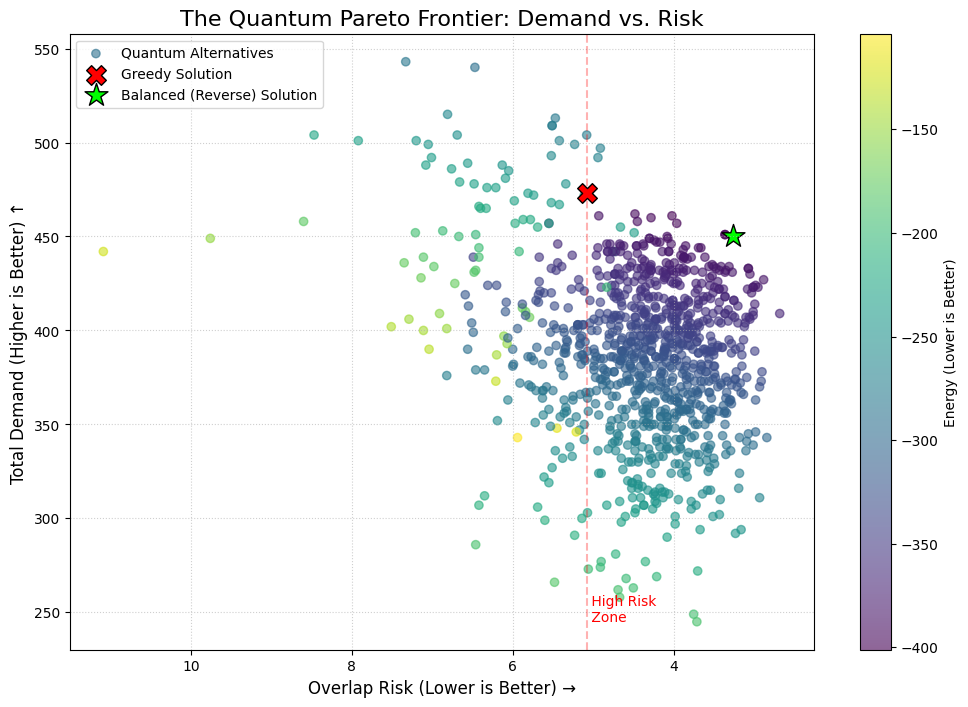

ANALYSIS:
Greedy is stuck at the extreme: Demand 473, Risk 5.08
Quantum found a diverse 'Cloud' of options.
Look for dots that are ABOVE or to the RIGHT of the Greedy solution.


In [29]:
# --- CELL 8: THE PARETO FRONTIER (The Real Quantum Advantage) ---
import matplotlib.pyplot as plt

print("7. Generating Pareto Frontier Analysis...")

# 1. Extract Data from the Quantum Sampleset
# We look at ALL 1000 solutions, not just the 'best' one
results = []
for sample, energy in zip(reverse_sampleset.record.sample, reverse_sampleset.record.energy):
    # Convert binary array to index list
    indices = [i for i, x in enumerate(sample) if x == 1]
    
    # Calculate KPIs for this specific sample
    metrics = calculate_kpis(indices, "Sample")
    # metrics format: [Name, Demand, Overlap]
    results.append({
        'demand': metrics[1],
        'overlap': metrics[2],
        'energy': energy
    })

# Convert to DataFrame for easy plotting
df = pd.DataFrame(results)

# 2. Plot the "Quantum Cloud"
plt.figure(figsize=(12, 8))

# Scatter plot of all Quantum Solutions (The Cloud)
plt.scatter(df['overlap'], df['demand'], c=df['energy'], cmap='viridis', alpha=0.6, label='Quantum Alternatives')
plt.colorbar(label='Energy (Lower is Better)')

# Plot the Greedy Solution (The Red Dot)
greedy_metrics = calculate_kpis(greedy_indices, "Greedy")
plt.scatter(greedy_metrics[2], greedy_metrics[1], color='red', s=200, marker='X', label='Greedy Solution', edgecolors='black')

# Plot the Reverse/Balanced Solution (The Green Star)
reverse_metrics = calculate_kpis(reverse_indices, "Reverse")
plt.scatter(reverse_metrics[2], reverse_metrics[1], color='lime', s=300, marker='*', label='Balanced (Reverse) Solution', edgecolors='black')

# 3. Add "Business Zones"
plt.axvline(x=greedy_metrics[2], color='red', linestyle='--', alpha=0.3)
plt.text(greedy_metrics[2], df['demand'].min(), " High Risk\n Zone", color='red')

plt.title("The Quantum Pareto Frontier: Demand vs. Risk", fontsize=16)
plt.xlabel("Overlap Risk (Lower is Better) →", fontsize=12)
plt.ylabel("Total Demand (Higher is Better) ↑", fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

# Invert X axis so "Lower Overlap" is on the right (visually intuitive as 'better')
plt.gca().invert_xaxis() 

plt.show()

print("ANALYSIS:")
print(f"Greedy is stuck at the extreme: Demand {greedy_metrics[1]}, Risk {greedy_metrics[2]}")
print(f"Quantum found a diverse 'Cloud' of options.")
print(f"Look for dots that are ABOVE or to the RIGHT of the Greedy solution.")